1. cell type 
2. coarse cell type

check elbo between wrong and correct ones

In [1]:
cd ..

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from RADOM.inference import Trajectory
from RADOM.poisson_mixture import PoissonMixture
from RADOM.gamma_poisson_mixture import GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

In [3]:
from scipy.stats import spearmanr
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

# Load data

In [4]:
metafile = "/home/tchari/metadata/bus_stim.h5ad"
loomfile = "/home/tchari/counts/clytia_stim/loom/clytia_SWall_allGenes.loom"
metadata = sc.read(metafile)
alldata = sc.read(loomfile)

In [5]:
metadata.obs

,batch,n_counts,n_countslog,louvain,condition,orgID,cellRanger_louvain,annos,annosSub
index,,,,,,,,,
AAACCCAAGAGCGACT-1,0,2423.0,3.384353,5,SW,3,1,Epidermal/Muscle,Exumbrella Epidermis
AAACCCAAGGCTCACC-1,0,10179.0,4.007705,1,DI,6,6,Neural,Neural Cells Early Stages
AAACCCAAGGGTACAC-1,0,17855.0,4.251760,1,KCl,11,11,Nematocyte,Early Nematocytes
AAACCCACACATGAAA-1,0,1830.0,3.262451,5,KCl,11,21,Nematocyte,Mechanosensory Cells-B
AAACCCACACCCTAAA-1,0,3852.0,3.585686,7,KCl,11,24,Gastroderm,GastroDigestive-F
...,...,...,...,...,...,...,...,...,...
TTTGTTGAGGGAGGTG-2,1,2633.0,3.420451,3,DI,5,7,Gastroderm,GastroDigestive-B
TTTGTTGAGTGTTCCA-2,1,11215.0,4.049799,12,SW,3,15,Gastroderm,GastroDigestive-D
TTTGTTGGTCCCTAAA-2,1,5748.0,3.759517,1,DI,8,11,Nematocyte,Early Nematocytes


In [6]:
meta_mask = [np.where(metadata.obs_names == index)[0][0] for index in alldata.obs["Barcode"]]
print(len(meta_mask))
alldata.obs["annos"] = (metadata.obs["annos"][meta_mask]).tolist()
alldata.obs["annosSub"] = (metadata.obs["annosSub"][meta_mask]).tolist()
alldata.obs["cellRanger_louvain"] = metadata.obs["cellRanger_louvain"][meta_mask].tolist()
alldata.obsm["X_pca"] = metadata.obsm["X_pca"][meta_mask]
alldata.obsm["X_tsne"] = metadata.obsm["X_tsne"][meta_mask]
alldata.obsm["X_umap"] = metadata.obsm["X_umap"][meta_mask]
alldata

5251


AnnData object with n_obs × n_vars = 5251 × 45872
    obs: 'Barcode', 'obs_names', 'annos', 'annosSub', 'cellRanger_louvain'
    var: 'var_names'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'matrix', 'spliced', 'unspliced'

## Select cells

the differentiating nematocytes are clusters 0 --> 12 --> 11 --> 23 --> 17 --> 10 --> 21

In [7]:
adata = alldata[alldata.obs["cellRanger_louvain"].isin([0,12,11,23,17,10,21])]

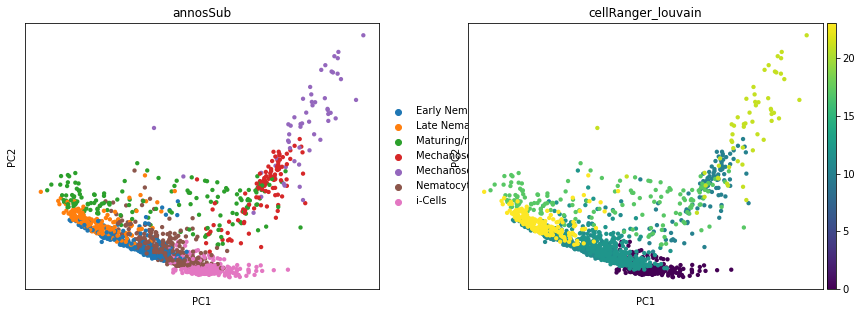

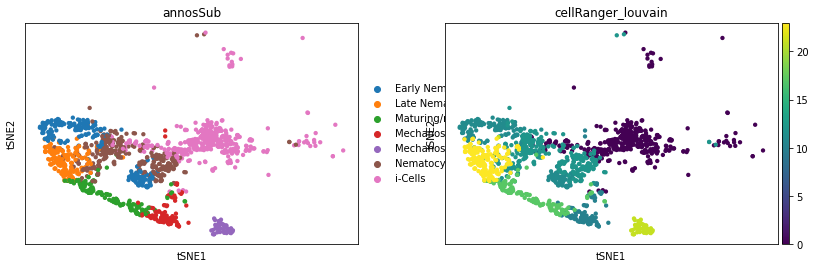

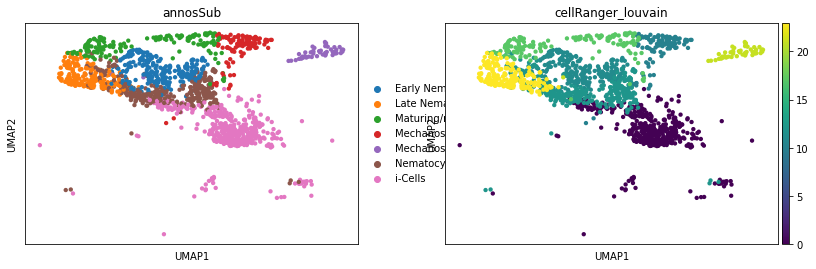

In [8]:
sc.pl.pca(adata,color=["annosSub","cellRanger_louvain"])
sc.pl.tsne(adata,color=["annosSub","cellRanger_louvain"])
sc.pl.umap(adata,color=["annosSub","cellRanger_louvain"])

In [9]:
clusters = adata.obs["cellRanger_louvain"]
Clusters = [0,12,11,23,17,10,21]

In [10]:
color_palette = ["#dde6d5","#a3b899","#667b68"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=8)

In [11]:
cell_colors = np.zeros((adata.n_obs,3))

for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    print(Cluster,idx.sum())
    cell_colors[idx] = cmap_cluster(i)[:3]

0 462
12 348
11 254
23 202
17 158
10 114
21 57


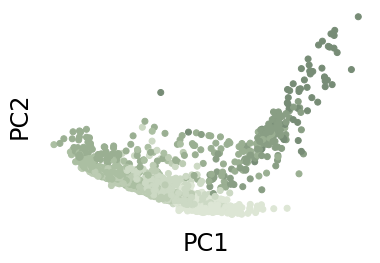

In [12]:
x = adata.obsm['X_pca']
fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

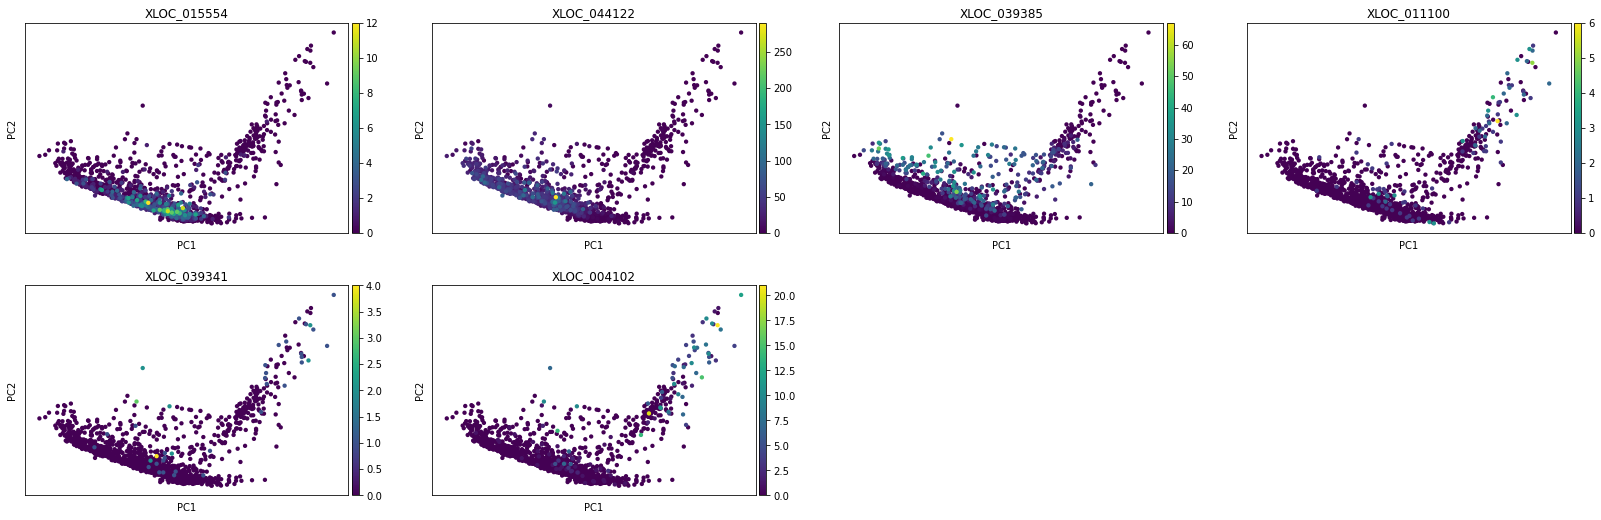

In [13]:
known_marker_genes = ['XLOC_015554','XLOC_044122','XLOC_039385','XLOC_011100','XLOC_039341','XLOC_004102']
marker_genes = ['XLOC_044122','XLOC_008048','XLOC_030068','XLOC_011074','XLOC_041365',
                'XLOC_041836','XLOC_011949','XLOC_015554','XLOC_039385','XLOC_045474',
                'XLOC_004102','XLOC_043404','XLOC_005363','XLOC_039341','XLOC_017845',
                'XLOC_018627','XLOC_011922','XLOC_003773','XLOC_011100','XLOC_019170']
sc.pl.pca(adata,color=known_marker_genes)

# Select genes

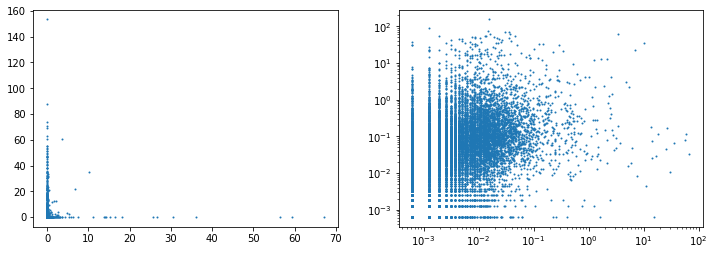

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [15]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.6982303258149837
s estimated by normalized covariance of total S counts = 0.7964618496973345
s estimated by normalized covariance of total counts = 0.7690809391634171
s estimated by total counts = 0.8245633027828725


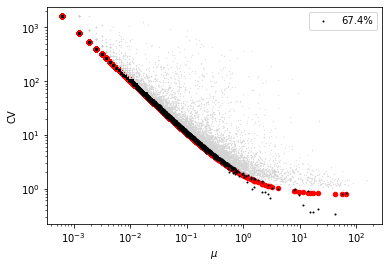

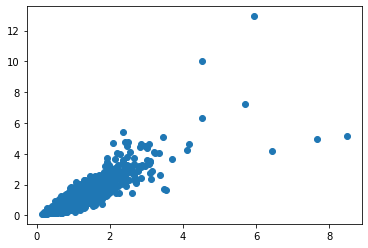

In [16]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)
a=1
s=min(s1,s2)
Pgene_mask = (X_bar > 0) & (X_var/(a*X_bar + s*X_bar**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,adata.X.toarray().mean(1)/adata.X.toarray().mean())

(1595, 233, 2)

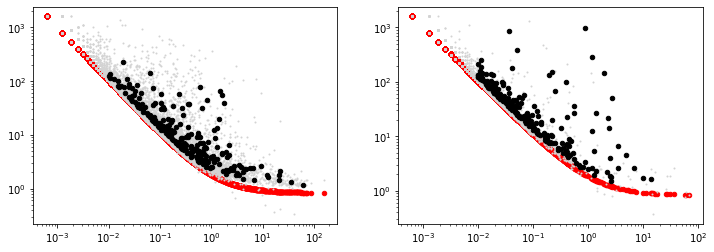

In [17]:
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.01) & (S_mean > 0.01) \
    & (np.abs(np.log10(S_mean/U_mean)) < 2) \
    & (U_var/(a*U_mean + s2*U_mean**2) > 1.2) \
    & (S_var/(a*S_mean + s2*S_mean**2) > 1.2)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

In [18]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['XLOC_045474'], dtype='object', name='Gene')


TypeError: 'AxesSubplot' object is not subscriptable

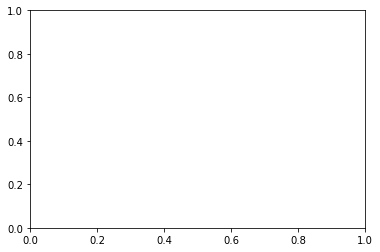

In [109]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

# Mixtures fitting

In [19]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

In [20]:
GPMs = []
for nc in range(3,8):
    GPM = GammaPoissonMixture(n_components=nc,verbose=0)
    Q, elbo = GPM.fit(X_mix,warm_start=False,epoch=5,n_init=3)
    GPMs.append(GPM)
    print(nc,GPM.compute_AIC(X_mix))

3 -373.6726758143634
4 -356.6894381706296
5 -346.05784217210385
6 -338.06312990811875
7 -337.0054646658359


In [21]:
for GPM in GPMs:
    print(GPM.compute_BIC(X_mix))

-376.0365016790506
-359.84176760243986
-349.9986751710371
-342.79246647417506
-342.52330479901525


In [22]:
GPM = GammaPoissonMixture(n_components=6,verbose=0)
Q, elbo = GPM.fit(X_mix,warm_start=False,epoch=10,n_init=5)
GPM.weights

array([0.16939189, 0.15710655, 0.23148887, 0.16223259, 0.24854087,
       0.03123923])

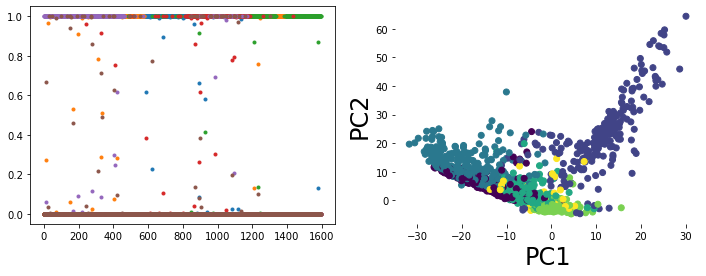

In [23]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=np.argmax(Q,axis=1));
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

In [24]:
GPM = GammaPoissonMixture(n_components=3,verbose=0)
Q, elbo = GPM.fit(X_mix,warm_start=False,epoch=10,n_init=5)

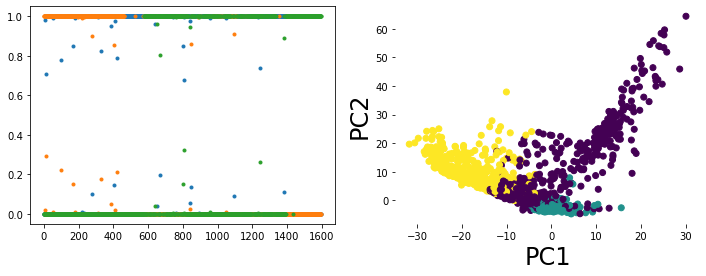

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=np.argmax(Q,axis=1));
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

Text(0.5, 1.0, 'intercept test p value')

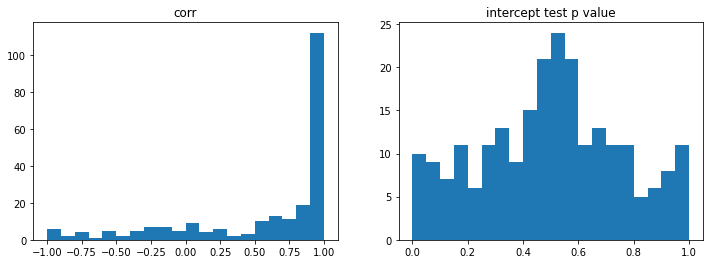

In [26]:
slope, intercept, corr, pval = linear_regression(GPM.theta)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(corr,bins=np.linspace(-1,1,21))
ax[0].set_title('corr')
ax[1].hist(pval,bins=np.linspace(0,1,21))
ax[1].set_title('intercept test p value')

# Trajectory fitting

In [27]:
elbos = {}
params={'r':rd,"lambda_tau":0,"lambda_a":0}

## Fine cluster

462
348
456
329


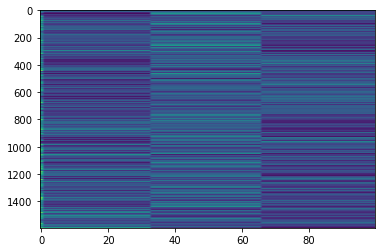

In [28]:
m=100
weight0 = 10*np.ones((adata.n_obs,m))
Clusters = [[0],[12],[11,23],[17,10,21]]
I = len(Clusters) - 1
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin(Cluster)
    print(idx.sum())
    if i ==0:
        weight0[idx,0] += 1
    else:
        weight0[idx,int((i-1)*m/I):int(i*m/I)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]
plt.imshow(weight0,aspect="auto")

In [30]:
prior = np.ones(m)
prior[0] += 32
prior /= prior.sum()

In [31]:
topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,prior=prior,parallel=True,n_threads=10,epoch=10)
print(traj.elbos[-1])

fitting with warm start


100%|██████████| 10/10 [01:09<00:00,  6.91s/it]

-375.9728439393853


[ 0.         24.23247389 48.        ]


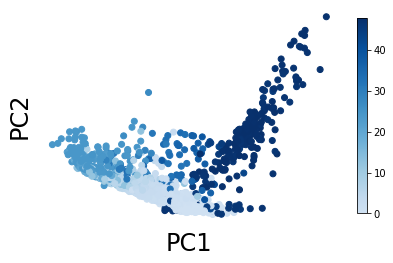

In [32]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

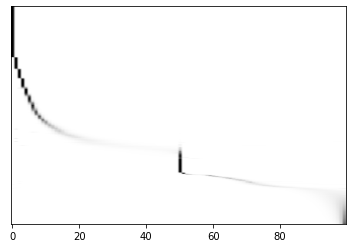

In [33]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

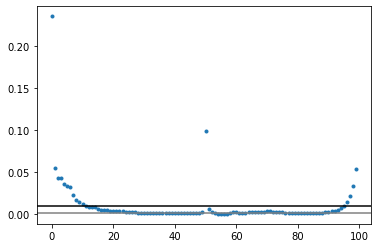

In [34]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

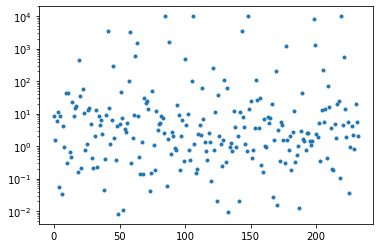

In [35]:
plt.plot(traj.theta[:,[-2]],'.')
plt.yscale('log')

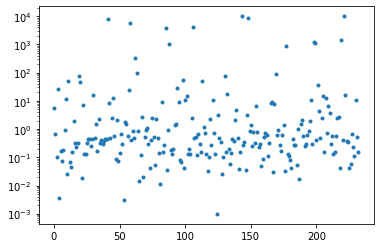

In [36]:
plt.plot(traj.theta[:,[-1]],'.')
plt.yscale('log')

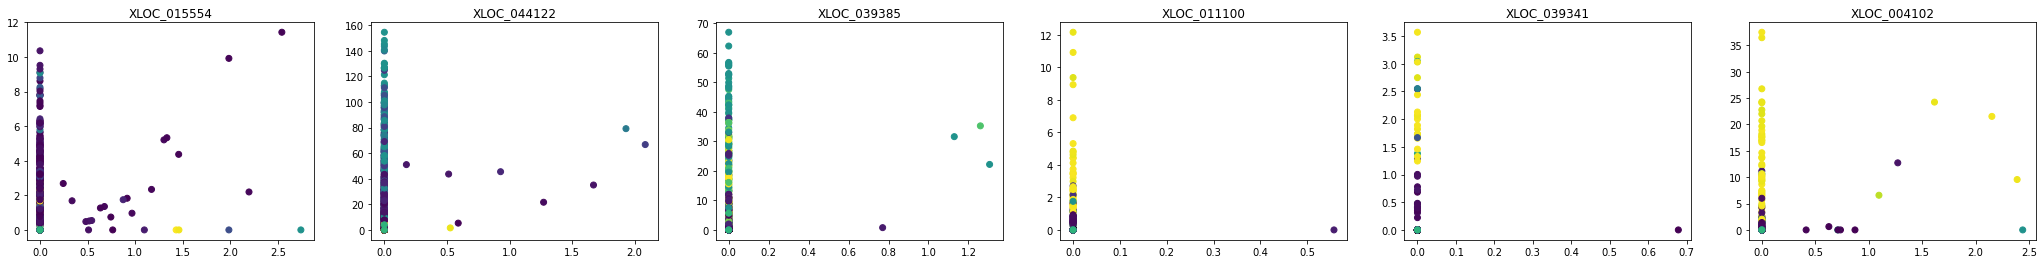

In [37]:
fig,ax = plt.subplots(1,len(known_marker_genes),figsize=(6*len(known_marker_genes),4))
for i,gene in enumerate(known_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

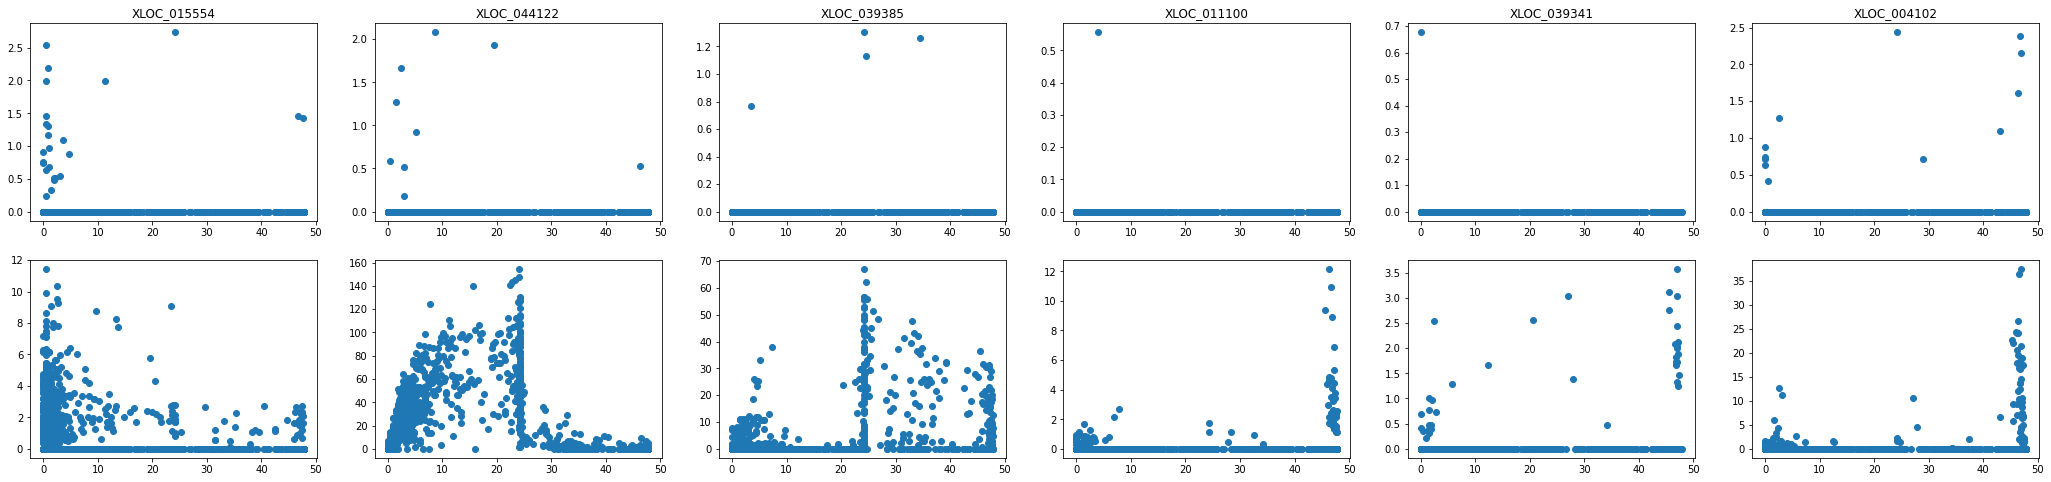

In [38]:
fig,ax = plt.subplots(2,len(known_marker_genes),figsize=(6*len(known_marker_genes),8))
for i,gene in enumerate(known_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

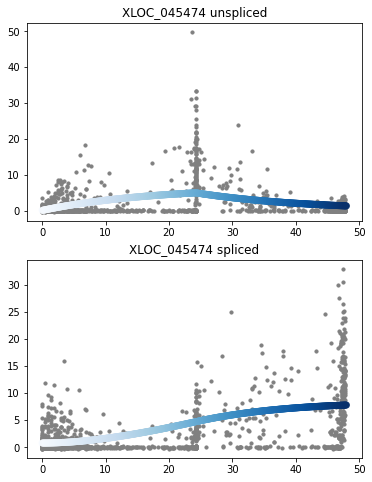

In [39]:
plot_y(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

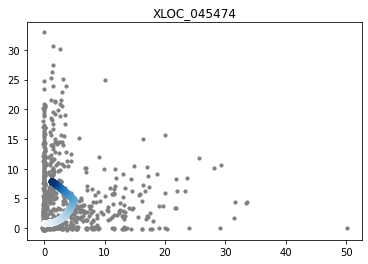

In [40]:
plot_phase(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

8


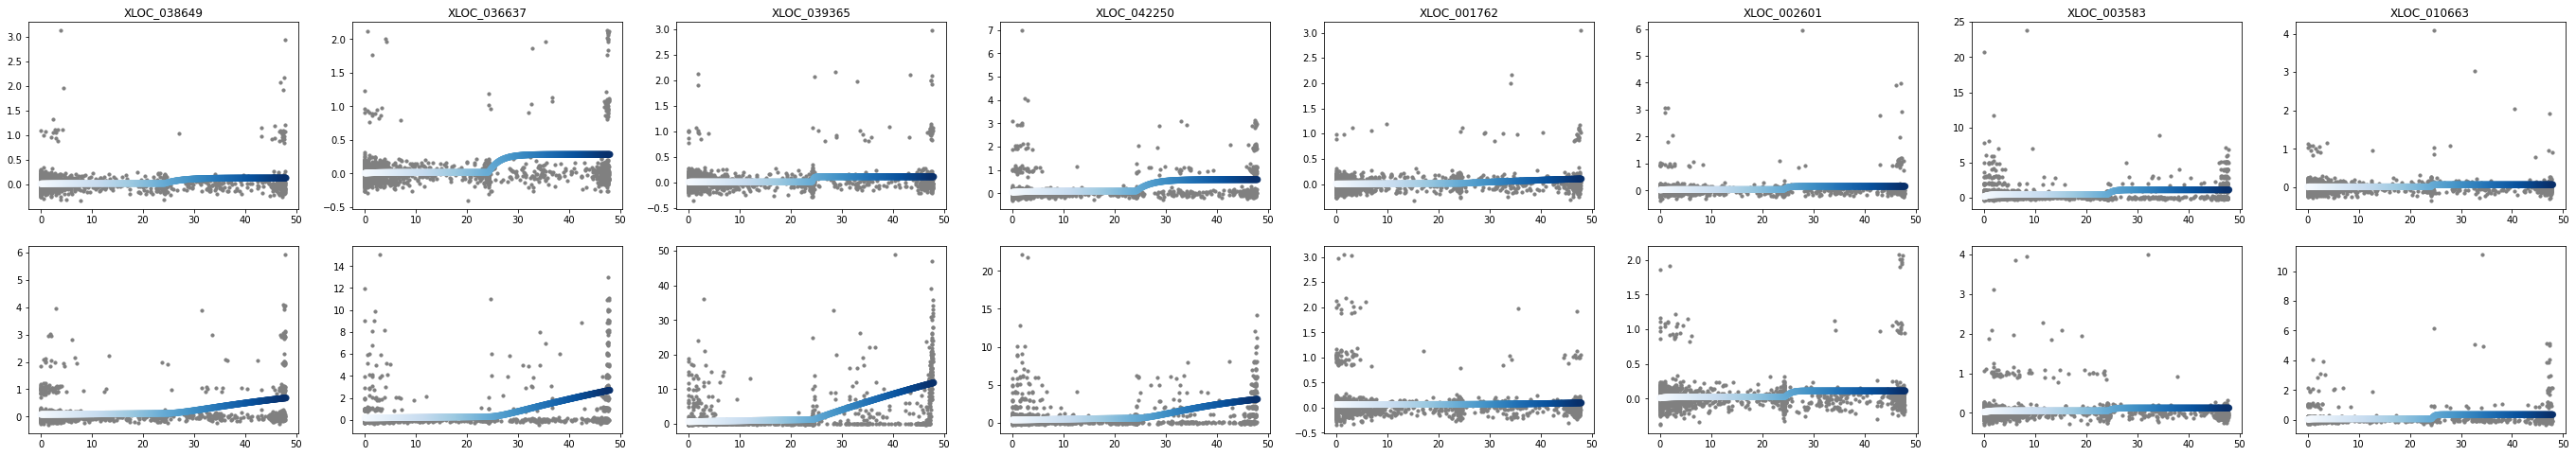

In [41]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

In [145]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

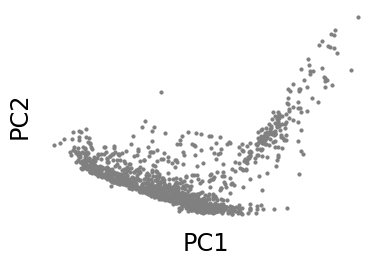

In [97]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [158]:
tau = (0,16,24,32,48)
topo = np.array([[0,1,2,3,4]])
trajs = []
for seed in tqdm(range(20)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 20/20 [07:49<00:00, 23.46s/it]


Text(0.5, 1.0, 'Random initialiazation')

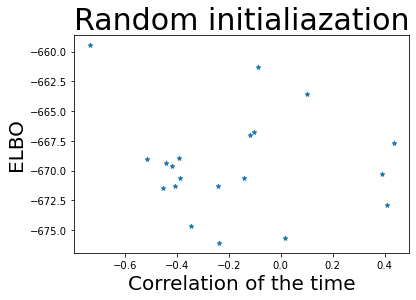

In [99]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [100]:
traj = trajs[np.argmax(elbos)]
np.max(elbos)

-659.4730044087285

[ 0.         23.34366535 48.        ]


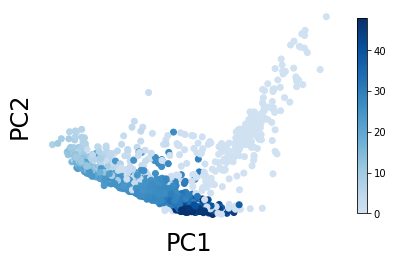

In [101]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

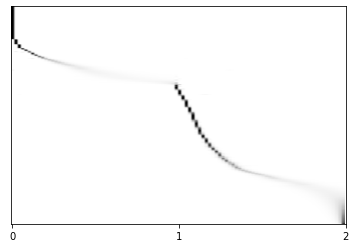

In [102]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

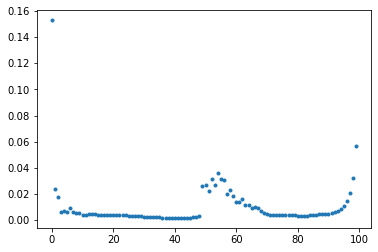

In [103]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

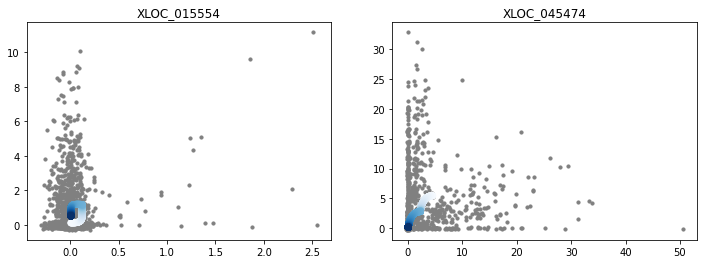

In [106]:
plot_phase(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

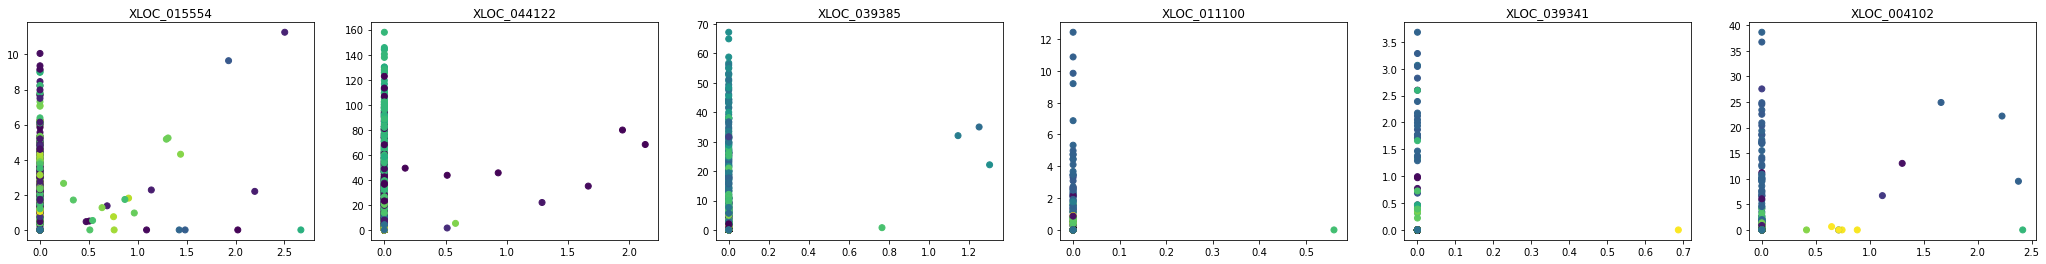

In [82]:
fig,ax = plt.subplots(1,len(known_marker_genes),figsize=(6*len(known_marker_genes),4))
for i,gene in enumerate(known_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

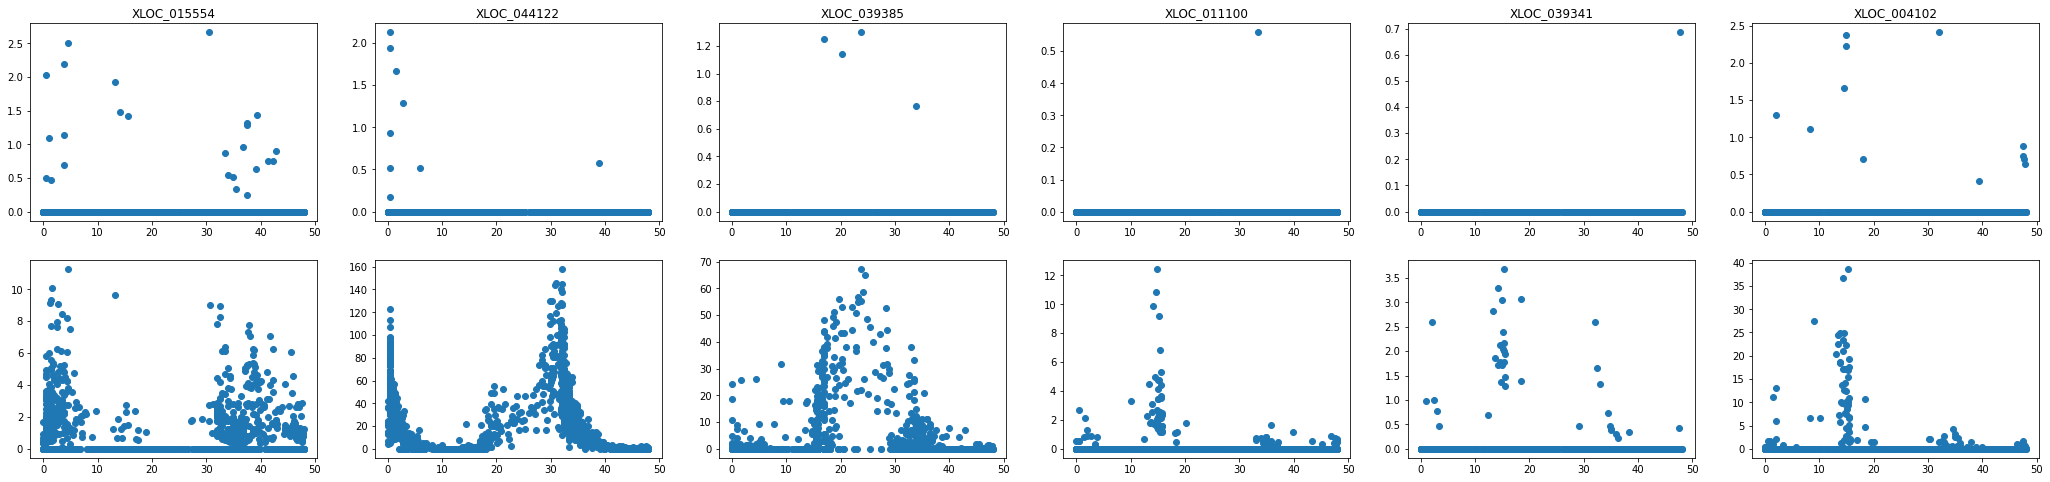

In [83]:
fig,ax = plt.subplots(2,len(known_marker_genes),figsize=(6*len(known_marker_genes),8))
for i,gene in enumerate(known_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

### two_species_ss_tau

In [ ]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(20)):
    traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]

In [ ]:
plt.hist(traj.theta[:,-3])

In [ ]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species

In [ ]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

In [ ]:
traj = trajs[np.argmax(corrs)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

# Synthetic data

In [ ]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=10)

In [ ]:
print(traj.elbos[-1])

In [ ]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
plot_t(traj,order_cells=True)

In [ ]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

In [ ]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

In [ ]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [ ]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()
trajs = []
for seed in tqdm(range(20)):
    syn_traj = Trajectory(syn_topo, syn_tau,  model="two_species_ss", restrictions={}, verbose=0)
    syn_traj = syn_traj.fit(syn_X, warm_start=False, fit_tau=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(syn_traj)

In [ ]:
corrs = []
elbos = []
for syn_traj in trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)